In [1]:
import re
import numpy as np
import collections
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
rules_normalizer = {
    'experience': 'pengalaman',
    'bagasi': 'bagasi',
    'kg': 'kampung',
    'kilo': 'kilogram',
    'g': 'gram',
    'grm': 'gram',
    'k': 'okay',
    'abgkat': 'abang dekat',
    'abis': 'habis',
    'ade': 'ada',
    'adoi': 'aduh',
    'adoii': 'aduhh',
    'aerodarat': 'kapal darat',
    'agkt': 'angkat',
    'ahh': 'ah',
    'ailior': 'air liur',
    'airasia': 'air asia x',
    'airasiax': 'penerbangan',
    'airline': 'penerbangan',
    'airlines': 'penerbangan',
    'airport': 'lapangan terbang',
    'airpot': 'lapangan terbang',
    'aje': 'sahaja',
    'ajelah': 'sahajalah',
    'ajer': 'sahaja',
    'ak': 'aku',
    'aq': 'aku',
    'all': 'semua',
    'ambik': 'ambil',
    'amek': 'ambil',
    'amer': 'amir',
    'amik': 'ambil',
    'ana': 'saya',
    'angkt': 'angkat',
    'anual': 'tahunan',
    'apapun': 'apa pun',
    'ape': 'apa',
    'arab': 'arab',
    'area': 'kawasan',
    'aritu': 'hari itu',
    'ask': 'tanya',
    'astro': 'astro',
    'at': 'pada',
    'attitude': 'sikap',
    'babi': 'khinzir',
    'back': 'belakang',
    'bag': 'beg',
    'bang': 'abang',
    'bangla': 'bangladesh',
    'banyk': 'banyak',
    'bard': 'pujangga',
    'bargasi': 'bagasi',
    'bawak': 'bawa',
    'bawanges': 'bawang',
    'be': 'jadi',
    'behave': 'berkelakuan baik',
    'belagak': 'berlagak',
    'berdisiplin': 'berdisplin',
    'berenti': 'berhenti',
    'beskal': 'basikal',
    'bff': 'rakan karib',
    'bg': 'bagi',
    'bgi': 'bagi',
    'biase': 'biasa',
    'big': 'besar',
    'bike': 'basikal',
    'bile': 'bila',
    'binawe': 'binatang',
    'bini': 'isteri',
    'bkn': 'bukan',
    'bla': 'bila',
    'blom': 'belum',
    'bnyak': 'banyak',
    'body': 'tubuh',
    'bole': 'boleh',
    'boss': 'bos',
    'bowling': 'boling',
    'bpe': 'berapa',
    'brand': 'jenama',
    'brg': 'barang',
    'briefing': 'taklimat',
    'brng': 'barang',
    'bro': 'abang',
    'bru': 'baru',
    'bruntung': 'beruntung',
    'bsikal': 'basikal',
    'btnggjwb': 'bertanggungjawab',
    'btul': 'betul',
    'buatlh': 'buatlah',
    'buh': 'letak',
    'buka': 'buka',
    'but': 'tetapi',
    'bwk': 'bawa',
    'by': 'dengan',
    'byr': 'bayar',
    'bz': 'sibuk',
    'camera': 'kamera',
    'camni': 'macam ini',
    'cane': 'macam mana',
    'cant': 'tak boleh',
    'carakerja': 'cara kerja',
    'care': 'jaga',
    'cargo': 'kargo',
    'cctv': 'kamera litar tertutup',
    'celako': 'celaka',
    'cer': 'cerita',
    'cheap': 'murah',
    'check': 'semak',
    'ciput': 'sedikit',
    'cite': 'cerita',
    'citer': 'cerita',
    'ckit': 'sikit',
    'ckp': 'cakap',
    'class': 'kelas',
    'cm': 'macam',
    'cmni': 'macam ini',
    'cmpak': 'campak',
    'committed': 'komited',
    'company': 'syarikat',
    'complain': 'aduan',
    'corn': 'jagung',
    'couldnt': 'tak boleh',
    'cr': 'cari',
    'crew': 'krew',
    'cube': 'cuba',
    'cuma': 'cuma',
    'curinyaa': 'curinya',
    'cust': 'pelanggan',
    'customer': 'pelanggan',
    'd': 'di',
    'da': 'dah',
    'dn': 'dan',
    'dahh': 'dah',
    'damaged': 'rosak',
    'dapek': 'dapat',
    'day': 'hari',
    'dazrin': 'dazrin',
    'dbalingnya': 'dibalingnya',
    'de': 'ada',
    'deep': 'dalam',
    'deliberately': 'sengaja',
    'depa': 'mereka',
    'dessa': 'desa',
    'dgn': 'dengan',
    'dh': 'dah',
    'didunia': 'di dunia',
    'diorang': 'mereka',
    'diorng': 'mereka',
    'direct': 'secara terus',
    'diving': 'junam',
    'dkt': 'dekat',
    'dlempar': 'dilempar',
    'dlm': 'dalam',
    'dlt': 'padam',
    'dlu': 'dulu',
    'done': 'siap',
    'dont': 'jangan',
    'dorg': 'mereka',
    'dpermudhkn': 'dipermudahkan',
    'dpt': 'dapat',
    'dr': 'dari',
    'dri': 'dari',
    'dsb': 'dan sebagainya',
    'dy': 'dia',
    'educate': 'mendidik',
    'ensure': 'memastikan',
    'everything': 'semua',
    'ewahh': 'wah',
    'expect': 'sangka',
    'fb': 'facebook',
    'fired': 'pecat',
    'first': 'pertama',
    'fkr': 'fikir',
    'flight': 'kapal terbang',
    'for': 'untuk',
    'free': 'percuma',
    'friend': 'kawan',
    'fyi': 'untuk pengetahuan anda',
    'gantila': 'gantilah',
    'gantirugi': 'ganti rugi',
    'gentlemen': 'lelaki budiman',
    'gerenti': 'jaminan',
    'gile': 'gila',
    'gk': 'juga',
    'gnti': 'ganti',
    'go': 'pergi',
    'gomen': 'kerajaan',
    'goment': 'kerajaan',
    'good': 'baik',
    'ground': 'tanah',
    'guarno': 'macam mana',
    'hampa': 'mereka',
    'hampeh': 'teruk',
    'hanat': 'jahanam',
    'handle': 'kawal',
    'handling': 'kawalan',
    'hanta': 'hantar',
    'haritu': 'hari itu',
    'hate': 'benci',
    'have': 'ada',
    'hawau': 'celaka',
    'henpon': 'telefon',
    'heran': 'hairan',
    'him': 'dia',
    'his': 'dia',
    'hmpa': 'mereka',
    'hntr': 'hantar',
    'hotak': 'otak',
    'hr': 'hari',
    'i': 'saya',
    'hrga': 'harga',
    'hrp': 'harap',
    'hu': 'sedih',
    'humble': 'merendah diri',
    'ibon': 'ikon',
    'ichi': 'inci',
    'idung': 'hidung',
    'if': 'jika',
    'ig': 'instagram',
    'iklas': 'ikhlas',
    'improve': 'menambah baik',
    'in': 'masuk',
    'isn t': 'tidak',
    'isyaallah': 'insyallah',
    'ja': 'sahaja',
    'japan': 'jepun',
    'jd': 'jadi',
    'je': 'saja',
    'jee': 'saja',
    'jek': 'saja',
    'jepun': 'jepun',
    'jer': 'saja',
    'jerr': 'saja',
    'jez': 'saja',
    'jg': 'juga',
    'jgk': 'juga',
    'jgn': 'jangan',
    'jgnla': 'janganlah',
    'jibake': 'celaka',
    'jjur': 'jujur',
    'job': 'kerja',
    'jobscope': 'skop kerja',
    'jogja': 'jogjakarta',
    'jpam': 'jpam',
    'jth': 'jatuh',
    'jugak': 'juga',
    'ka': 'ke',
    'kalo': 'kalau',
    'kalu': 'kalau',
    'kang': 'nanti',
    'kantoi': 'temberang',
    'kasi': 'beri',
    'kat': 'dekat',
    'kbye': 'ok bye',
    'kearah': 'ke arah',
    'kecik': 'kecil',
    'keja': 'kerja',
    'keje': 'kerja',
    'kejo': 'kerja',
    'keksongan': 'kekosongan',
    'kemana': 'ke mana',
    'kene': 'kena',
    'kenekan': 'kenakan',
    'kesah': 'kisah',
    'ketempat': 'ke tempat',
    'kije': 'kerja',
    'kijo': 'kerja',
    'kiss': 'cium',
    'kite': 'kita',
    'kito': 'kita',
    'kje': 'kerja',
    'kjr': 'kerja',
    'kk': 'okay',
    'kmi': 'kami',
    'kt': 'kat',
    'tlg': 'tolong',
    'kl': 'kuala lumpur',
    'klai': 'kalau',
    'klau': 'kalau',
    'klia': 'klia',
    'klo': 'kalau',
    'klu': 'kalau',
    'kn': 'kan',
    'knapa': 'kenapa',
    'kne': 'kena',
    'ko': 'kau',
    'kompom': 'sah',
    'korang': 'kamu semua',
    'korea': 'korea',
    'korg': 'kamu semua',
    'kot': 'mungkin',
    'krja': 'kerja',
    'ksalahan': 'kesalahan',
    'kta': 'kita',
    'kuar': 'keluar',
    'kut': 'mungkin',
    'la': 'lah',
    'laa': 'lah',
    'lahabau': 'celaka',
    'lahanat': 'celaka',
    'lainda': 'lain dah',
    'lak': 'pula',
    'last': 'akhir',
    'le': 'lah',
    'leader': 'ketua',
    'leave': 'pergi',
    'ler': 'lah',
    'less': 'kurang',
    'letter': 'surat',
    'lg': 'lagi',
    'lgi': 'lagi',
    'lngsong': 'langsung',
    'lol': 'hehe',
    'lorr': 'lah',
    'low': 'rendah',
    'lps': 'lepas',
    'luggage': 'bagasi',
    'lumbe': 'lumba',
    'lyak': 'layak',
    'maap': 'maaf',
    'maapkan': 'maafkan',
    'mahai': 'mahal',
    'mampos': 'mampus',
    'mart': 'kedai',
    'mau': 'mahu',
    'mcm': 'macam',
    'mcmtu': 'macam itu',
    'memerlukn': 'memerlukan',
    'mengembirakan': 'menggembirakan',
    'mengmbilnyer': 'mengambilnya',
    'mengtasi': 'mengatasi',
    'mg': 'memang',
    'mihak': 'memihak',
    'min': 'admin',
    'mingu': 'minggu',
    'mintak': 'minta',
    'mjtuhkn': 'menjatuhkan',
    'mkyong': 'mak yong',
    'mlibatkn': 'melibatkan',
    'mmg': 'memang',
    'mmnjang': 'memanjang',
    'mmpos': 'mampus',
    'mn': 'mana',
    'mna': 'mana',
    'mntak': 'minta',
    'mntk': 'minta',
    'mnyusun': 'menyusun',
    'mood': 'suasana',
    'most': 'paling',
    'mr': 'tuan',
    'msa': 'masa',
    'msia': 'malaysia',
    'mst': 'mesti',
    'mu': 'awak',
    'much': 'banyak',
    'muko': 'muka',
    'mum': 'emak',
    'n': 'dan',
    'nah': 'nah',
    'nanny': 'nenek',
    'napo': 'kenapa',
    'nati': 'nanti',
    'ngan': 'dengan',
    'ngn': 'dengan',
    'ni': 'ini',
    'nie': 'ini',
    'nii': 'ini',
    'nk': 'nak',
    'nmpk': 'nampak',
    'nye': 'nya',
    'ofis': 'pejabat',
    'ohh': 'oh',
    'oii': 'hoi',
    'one': 'satu',
    'online': 'dalam talian',
    'or': 'atau',
    'org': 'orang',
    'orng': 'orang',
    'otek': 'otak',
    'p': 'pergi',
    'paid': 'dah bayar',
    'palabana': 'kepala otak',
    'pasni': 'lepas ini',
    'passengers': 'penumpang',
    'passengger': 'penumpang',
    'pastu': 'lepas itu',
    'pd': 'pada',
    'pegi': 'pergi',
    'pekerje': 'pekerja',
    'pekrja': 'pekerja',
    'perabih': 'perabis',
    'perkerja': 'pekerja',
    'pg': 'pergi',
    'phuii': 'puih',
    'pikir': 'fikir',
    'pilot': 'juruterbang',
    'pk': 'fikir',
    'pkerja': 'pekerja',
    'pkerjaan': 'pekerjaan',
    'pki': 'pakai',
    'please': 'tolong',
    'pls': 'tolong',
    'pn': 'pun',
    'pnh': 'pernah',
    'pnt': 'penat',
    'pnya': 'punya',
    'pon': 'pun',
    'priority': 'keutamaan',
    'properties': 'harta benda',
    'ptugas': 'petugas',
    'pub': 'kelab malam',
    'pulak': 'pula',
    'puye': 'punya',
    'pwrcuma': 'percuma',
    'pyahnya': 'payahnya',
    'quality': 'kualiti',
    'quit': 'keluar',
    'ramly': 'ramly',
    'rege': 'harga',
    'reger': 'harga',
    'report': 'laporan',
    'resigned': 'meletakkan jawatan',
    'respect': 'hormat',
    'rizal': 'rizal',
    'rosak': 'rosak',
    'rosok': 'rosak',
    'rse': 'rasa',
    'sacked': 'buang',
    'sado': 'tegap',
    'salute': 'sanjung',
    'sam': 'sama',
    'same': 'sama',
    'samp': 'sampah',
    'sbb': 'sebab',
    'sbgai': 'sebagai',
    'sblm': 'sebelum',
    'sblum': 'sebelum',
    'sbnarnya': 'sebenarnya',
    'sbum': 'sebelum',
    'sdg': 'sedang',
    'sebb': 'sebab',
    'sebijik': 'sebiji',
    'see': 'lihat',
    'seen': 'dilihat',
    'selangor': 'selangor',
    'selfie': 'swafoto',
    'sempoi': 'cantik',
    'senaraihitam': 'senarai hitam',
    'seorg': 'seorang',
    'service': 'perkhidmatan',
    'sgt': 'sangat',
    'shared': 'kongsi',
    'shirt': 'kemeja',
    'shut': 'tutup',
    'sib': 'nasib',
    'skali': 'sekali',
    'sket': 'sikit',
    'sma': 'sama',
    'smoga': 'semoga',
    'smpoi': 'cantik',
    'sndiri': 'sendiri',
    'sndr': 'sendiri',
    'sndri': 'sendiri',
    'sne': 'sana',
    'so': 'jadi',
    'sop': 'tatacara pengendalian piawai',
    'sorang': 'seorang',
    'spoting': 'pembintikan',
    'sronok': 'seronok',
    'ssh': 'susah',
    'staff': 'staf',
    'standing': 'berdiri',
    'start': 'mula',
    'steady': 'mantap',
    'stiap': 'setiap',
    'stress': 'stres',
    'student': 'pelajar',
    'study': 'belajar',
    'studycase': 'kajian kes',
    'sure': 'pasti',
    'sykt': 'syarikat',
    'tah': 'entah',
    'taik': 'tahi',
    'takan': 'tak akan',
    'takat': 'setakat',
    'takde': 'tak ada',
    'takkan': 'tak akan',
    'taknak': 'tak nak',
    'tang': 'tentang',
    'tanggungjawab': 'bertanggungjawab',
    'taraa': 'sementara',
    'tau': 'tahu',
    'tbabit': 'terbabit',
    'team': 'pasukan',
    'terbaekk': 'terbaik',
    'teruknye': 'teruknya',
    'tgk': 'tengok',
    'that': 'itu',
    'thinking': 'fikir',
    'those': 'itu',
    'time': 'masa',
    'tk': 'tak',
    'tnggongjwb': 'tanggungjawab',
    'tngok': 'tengok',
    'tngu': 'tunggu',
    'to': 'kepada',
    'tosak': 'rosak',
    'tp': 'tapi',
    'tpi': 'tapi',
    'tpon': 'telefon',
    'transfer': 'pindah',
    'trgelak': 'tergelak',
    'ts': 'tan sri',
    'tstony': 'tan sri tony',
    'tu': 'itu',
    'tuh': 'itu',
    'tula': 'itulah',
    'umeno': 'umno',
    'unfortunately': 'malangnya',
    'unhappy': 'tidak gembira',
    'up': 'naik',
    'upkan': 'naikkan',
    'ur': 'awak',
    'utk': 'untuk',
    'very': 'sangat',
    'viral': 'tular',
    'vote': 'undi',
    'warning': 'amaran',
    'warranty': 'waranti',
    'wassap': 'whatsapp',
    'wat': 'apa',
    'weii': 'wei',
    'well': 'maklumlah',
    'win': 'menang',
    'with': 'dengan',
    'wt': 'buat',
    'x': 'tak',
    'tw': 'tahu',
    'ye': 'ya',
    'yee': 'ya',
    'yg': 'yang',
    'yng': 'yang',
    'you': 'awak',
    'your': 'awak',
    'sakai': 'selekeh',
    'rmb': 'billion ringgit',
    'rmj': 'juta ringgit',
    'rmk': 'ribu ringgit',
    'rm': 'ringgit',
}

In [3]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = [e for e in hujung if word.endswith(e)]
    if len(hujung_result):
        hujung_result = max(hujung_result, key = len)
        if len(hujung_result):
            word = word[: -len(hujung_result)]
    permulaan_result = [e for e in permulaan if word.startswith(e)]
    if len(permulaan_result):
        permulaan_result = max(permulaan_result, key = len)
        if len(permulaan_result):
            word = word[len(permulaan_result) :]
    return word

def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string.lower()).strip()
    string = [rules_normalizer.get(w, w) for w in string.split()]
    string = [naive_stemmer(word) for word in string]
    return ' '.join([word for word in string if len(word) > 1])


def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k, UNK)
    return X

In [4]:
classification_textcleaning('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')

'raja benar sangat benci rakyat minyak naik gala'

In [5]:
df = pd.read_csv('sentiment-data-v2.csv')
Y = LabelEncoder().fit_transform(df.label)
with open('polarity-negative-translated.txt','r') as fopen:
    texts = fopen.read().split('\n')
labels = [0] * len(texts)

with open('polarity-positive-translated.txt','r') as fopen:
    positive_texts = fopen.read().split('\n')
labels += [1] * len(positive_texts)
texts += positive_texts
texts += df.iloc[:,1].tolist()
labels += Y.tolist()

assert len(labels) == len(texts)

In [6]:
import json
with open('bm-amazon.json') as fopen:
    amazon = json.load(fopen)
    
with open('bm-imdb.json') as fopen:
    imdb = json.load(fopen)
    
with open('bm-yelp.json') as fopen:
    yelp = json.load(fopen)
    
texts += amazon['negative']
labels += [0] * len(amazon['negative'])
texts += amazon['positive']
labels += [1] * len(amazon['positive'])

texts += imdb['negative']
labels += [0] * len(imdb['negative'])
texts += imdb['positive']
labels += [1] * len(imdb['positive'])

texts += yelp['negative']
labels += [0] * len(yelp['negative'])
texts += yelp['positive']
labels += [1] * len(yelp['positive'])

In [7]:
import os
for i in [i for i in os.listdir('negative') if 'Store' not in i]:
    with open('negative/'+i) as fopen:
        a = json.load(fopen)
        texts += a
        labels += [0] * len(a)

In [8]:
import os
for i in [i for i in os.listdir('positive') if 'Store' not in i]:
    with open('positive/'+i) as fopen:
        a = json.load(fopen)
        texts += a
        labels += [1] * len(a)

In [9]:
len(texts),len(labels)

(675023, 675023)

In [10]:
for i in range(len(texts)):
    texts[i] = classification_textcleaning(texts[i])

In [11]:
texts[-10:]

['ada anda yiar tentang gatur tidur yang baru tidak lama lagi yusun mula ada yang baik ntiasa asa begitu jaya lepas itu',
 'lamat pagi dunia',
 'sini rumah pupu saya',
 'mungkin ini lebih anda',
 'ima kasih saya erlukan',
 'neraka windows luar dari julat harga saya cuali jika tidak',
 'neah saya harap ha enang mbali catat dalam tweet akhir saya',
 'aww saya benar benar minta maaf tentang itu tidak ada apa apa yang sa deng jadi asi tidak anda lihat quot quot malam kido',
 'saya tidak sabar untuk lihat apa kara yang akjub yang anda datang tidak nah lupa anda luar biasa',
 'deng cara saya embali dewi matahari malam tadi anda sasha sangat agum saya boleh onton filem itu ulang kali']

In [12]:
labels[-10:]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 120097
Most common words [('saya', 533028), ('yang', 204446), ('tidak', 164296), ('untuk', 129707), ('anda', 126091), ('hari', 88975)]
Sample data [2667, 229, 363, 235, 235, 94, 1357, 5, 78, 678] ['ringkas', 'bodoh', 'bosan', 'kanak', 'kanak', 'lelaki', 'remaja', 'yang', 'begitu', 'muda']


In [14]:

class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        W = tf.get_variable(
            'w',
            shape = (size_layer, dimension_output),
            initializer = tf.glorot_uniform_initializer(),
        )
        b = tf.get_variable(
            'b',
            shape = (dimension_output),
            initializer = tf.zeros_initializer(),
        )
        self.logits = tf.add(tf.matmul(outputs[:, -1], W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [15]:
size_layer = 256
num_layers = 2
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 100

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [16]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [17]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel',
 'rnn/attention_wrapper/bahdanau_attention/attention_v',
 'rnn/attention_wrapper/attention_layer/kernel',
 'w',
 'b',
 'logits',
 'gradients/logits_grad/Shape',
 'gradients/logits_grad/Shape_1',
 'gradients/logits_grad/BroadcastGradientArgs',
 'gradients/logits_grad/Sum',
 'gradients/logits_grad/Reshape',
 'gradients/logits_grad/Sum_1',
 'gradients/logits_grad/Reshape_1',
 'gradients/logits_grad/tuple/group_deps',
 'gradients/logits_grad/tuple/control_dependency',
 'gradients/logits_grad/tuple/control_dependency_1',
 'alphas']

In [18]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(120101, 256) dtype=float32_ref>,
 <tf.Variable 'memory_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/attention_v:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/attention_layer/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'w:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'b:0' shape=(2

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(
    texts, labels, test_size = 0.2
)

In [20]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = str_idx(train_X[i : min(i + batch_size, len(train_X))], dictionary, maxlen)
        batch_y = train_Y[i : min(i + batch_size, len(train_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
        batch_y = test_Y[i : min(i + batch_size, len(test_X))]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.779121
time taken: 6174.380074739456
epoch: 0, training loss: 0.498860, training acc: 0.753909, valid loss: 0.464861, valid acc: 0.779121



train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.779121, current acc: 0.791210
time taken: 5513.241537094116
epoch: 1, training loss: 0.444138, training acc: 0.790736, valid loss: 0.445412, valid acc: 0.791210



train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

epoch: 2, pass acc: 0.791210, current acc: 0.796068
time taken: 5513.38360285759
epoch: 2, training loss: 0.418108, training acc: 0.806448, valid loss: 0.437184, valid acc: 0.796068



train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

epoch: 3, pass acc: 0.796068, current acc: 0.797134
time taken: 5514.022459030151
epoch: 3, training loss: 0.396623, training acc: 0.818872, valid loss: 0.437425, valid acc: 0.797134



train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

time taken: 5513.8161444664
epoch: 4, training loss: 0.375607, training acc: 0.830799, valid loss: 0.444038, valid acc: 0.796275



train minibatch loop:   0%|          | 0/16876 [00:00<?, ?it/s]

time taken: 5542.729185819626
epoch: 5, training loss: 0.353540, training acc: 0.842987, valid loss: 0.455322, valid acc: 0.794943



test minibatch loop: 100%|██████████| 4219/4219 [06:11<00:00, 11.35it/s, accuracy=0.724, cost=0.602]

time taken: 5540.525487422943
epoch: 6, training loss: 0.330596, training acc: 0.854822, valid loss: 0.471969, valid acc: 0.792239

break epoch:7



In [21]:
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [22]:
text = classification_textcleaning('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.8631272 , 0.13687284]], dtype=float32)

In [23]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = str_idx(test_X[i : min(i + batch_size, len(test_X))], dictionary, maxlen)
    batch_y = test_Y[i : min(i + batch_size, len(test_X))]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 4219/4219 [06:06<00:00, 11.62it/s]


In [24]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.79      0.81      0.80     70549
   positive       0.79      0.77      0.78     64456

avg / total       0.79      0.79      0.79    135005



In [25]:
import json
with open('bahdanau-sentiment.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [26]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [27]:
freeze_graph('bahdanau', strings)

INFO:tensorflow:Restoring parameters from bahdanau/model.ckpt
INFO:tensorflow:Froze 11 variables.
INFO:tensorflow:Converted 11 variables to const ops.
403 ops in the final graph.


In [28]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [29]:
g = load_graph('bahdanau/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [31]:
news_string = 'kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya'

In [32]:
text = classification_textcleaning(news_string)
new_vector = str_idx([text], dictionary, len(text.split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

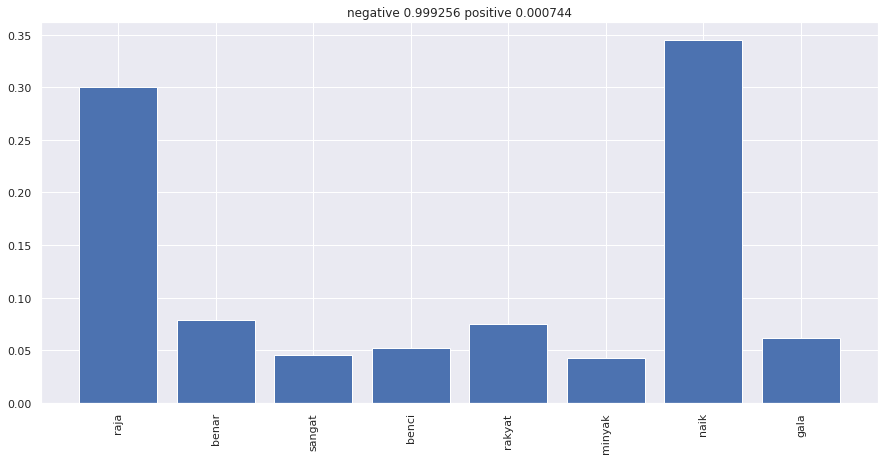

In [33]:
plt.figure(figsize = (15, 7))
labels = [word for word in text.split()]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()